# DEMO: Hyperparameter Tuning via GridSearchCV

## Imports

In [1]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T

from snowflake.ml.modeling.xgboost import XGBClassifier
from snowflake.ml.modeling.model_selection import GridSearchCV

import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Create Snowpark Session

In [2]:
with open('creds.json') as f:
    connection_parameters = json.load(f)

In [3]:
session = Session.builder.configs(connection_parameters).create()
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database and schema: "HOL_DB"."PUBLIC"
Current Warehouse: "HOL_WH"


# Model Building

Parameter-Tuning is computationally expensive. So we will use a Snowpark-Optimized Warehouse for better performance.

In [4]:
session.use_warehouse('HOL_WH_HIGH_MEM')

In [5]:
train_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TRAIN')
test_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TEST')

In [6]:
feature_cols = train_sdf.columns
feature_cols.remove('TARGET')
feature_cols.remove('ID')
target_col = 'TARGET'

grid_search = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid={
        'n_estimators':[10,50,100],
        'max_depth':[2,3,4]
        },
    n_jobs = -1,
    input_cols = feature_cols,
    label_cols = target_col,
    output_cols = 'PREDICTION',
    scoring="f1",
    )

grid_search.fit(train_sdf)

## Analyze GridSearch Results

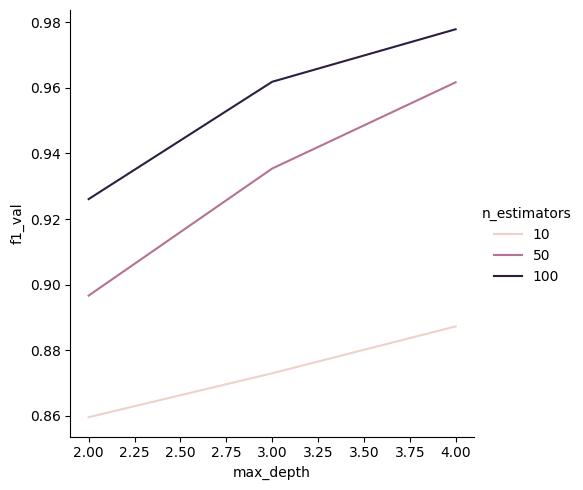

In [7]:
# Analyze grid search results
gs_results = grid_search.to_sklearn().cv_results_
n_estimators_val = []
max_depth_val = []
for param_dict in gs_results["params"]:
    n_estimators_val.append(param_dict["n_estimators"])
    max_depth_val.append(param_dict["max_depth"])

f1_val = gs_results["mean_test_score"]
gs_results_df = pd.DataFrame(data={"n_estimators":n_estimators_val,
                                   "max_depth":max_depth_val, 
                                   'f1_val':f1_val})
sns.relplot(data=gs_results_df, x="max_depth", y="f1_val", hue="n_estimators", kind='line')
plt.show()